In [186]:
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.impute import KNNImputer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# seed
np.random.seed(0)

# Dataset 1

## Funciones para demostración empírica

In [208]:
"""
    Gamma: retorna el margen
    input:
        X: numpy array (n, d)
        Y: numpy array (n)
    output:
        gamma: float
"""
def gamma(X, Y):
    perceptron = Perceptron(tol=None)
    perceptron.fit(X, Y)
    Y_predicted = perceptron.predict(X)
    gamma = np.inf
    
    for i in range(X.shape[0]):
        if Y[i] * Y_predicted[i] < gamma:
            gamma = Y[i] * Y_predicted[i]
        
    return gamma

"""
    linearly_separable: Verifica si data es linealmente separable
    input:
        X: numpy array (n, d)
        Y: numpy array (n)
    output:
        bool
"""
def linearly_separable(X, Y):
    perceptron = Perceptron(tol=None)
    perceptron.fit(X, Y)
    Y_predicted = perceptron.predict(X)
    
    for i in range(X.shape[0]):
        if Y[i] * Y_predicted[i] < 0:
            return False
        
    return True

"""
    convert_to_ls: borra elementos que no sirven
    input:
        X: numpy array (n, d)
        Y: numpy array (n)
    output:
        X, Y
"""
def convert_to_ls(X, Y):
    
    perceptron = Perceptron(tol=None)
    perceptron.fit(X, Y)
    Y_predicted = perceptron.predict(X)
    
    len_Y = Y.shape[0]
    i = 0
    
    while i < len_Y:
        if Y[i] * Y_predicted[i] < 0:
            print(X.shape)
            print(Y.shape)
            print(i)
            print("\n")
            
            Y = np.delete(Y, i)
            X = np.delete(X, i)
            Y_predicted = np.delete(Y_predicted, i)
            
            len_Y = Y.shape[0]
        else :
            i += 1
    
    return X, Y

"""
    max_norm: calcula la maxima norma de los vectores filas de X,
        donde cada x_i es un vecetor de atributos
    input:
        X: numpy array
    output:
        max_norm_x: float
"""
def max_norm(X):
    max_norm_x = 0
    for x in X:
        if np.linalg.norm(x) >= max_norm_x:
            max_norm_x = np.linalg.norm(x)
    return max_norm_x

## Carga data

In [209]:
data = pd.read_csv('datasets/breast-cancer-wisconsin.csv', sep=",")

data.columns = [
    "ID",
    "Clump Thickness",
    "Uniformity of Cell Size",
    "Uniformity of Cell Shape",
    "Marginal Adhesion",
    "Single Epithelial Cell Size",
    "Bare Nuclei",
    "Bland Chromatin",
    "Normal Nucleoli",
    "Mitoses",
    "Result"
]

print("Shape breast cancer wisconsin: ", data.shape)

Shape breast cancer wisconsin:  (698, 11)


## Imputación (Knn) y detalles encoding

In [210]:
data = data.drop("ID", axis=1)

data = data.replace(['?'], np.nan)

imputer = KNNImputer(n_neighbors=5)
data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns)

"""data.loc[data['Result'] == "Benign", 'Result'] = 2
data.loc[data['Result'] == "Malignant", 'Result'] = 4
"""

data.loc[data['Result'] == 2, 'Result'] = "Benign"
data.loc[data['Result'] == 4, 'Result'] = "Malignant"

print("Shape breast cancer wisconsin: ", data.shape)

Shape breast cancer wisconsin:  (698, 10)


## Análisis exploratorio

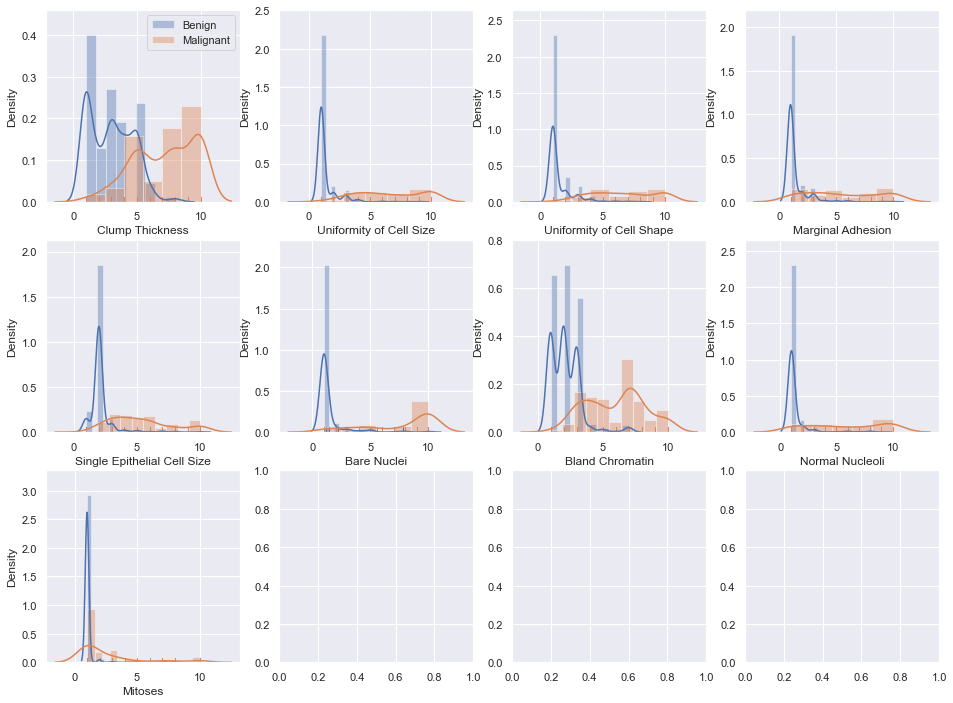

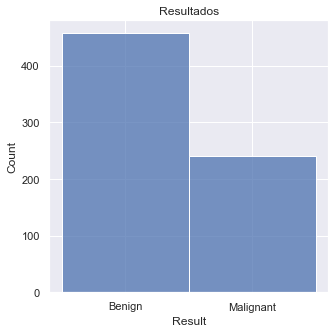

In [211]:
fig, axes = plt.subplots(figsize=(16, 12), nrows=3, ncols=4)

for i, column in enumerate(data.columns[:-1]):
    for result in ["Benign", "Malignant"]:
        target = data.loc[data['Result'] == result]
        sns.distplot(target[column], rug=True, kde=True, ax=axes[i//4,i%4], label=result)
    if i==0:
        axes[0,0].legend()
        
"""data.loc[data['Result'] == "Benign", 'Result'] = 2
data.loc[data['Result'] == "Malignant", 'Result'] = 4"""

fig, ax = plt.subplots(figsize=(5, 5),nrows=1)
sns.histplot(data=data["Result"], palette="Blues_d",ax=ax, label=["Benign", "Malignant"])
ax.set_title('Resultados')
plt.show()

## División data

In [212]:
data.loc[data["Result"] == "Benign" ,"Result"] = 1
data.loc[data["Result"] == "Malignant", "Result"] = -1

data["Result"] = data["Result"].astype(int)

predictors = data.columns[:-1]
X = data[predictors]
info = data[predictors]

y = data["Result"]

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

## $\gamma$, R y cota

In [213]:
max_norm_dataset_1 = max_norm(X_train_vals)
g = gamma(X, y)
bound = max_norm_dataset_1**2 / g**2

print("R:", max_norm_dataset_1)
print("Gamma: ", g)
print("Cota: ", bound)
print("Linealmente separables?:", linearly_separable(X, y))

R: 28.5657137141714
Gamma:  -1
Cota:  816.0000000000001
Linealmente separables?: False


## Perceptrón directo

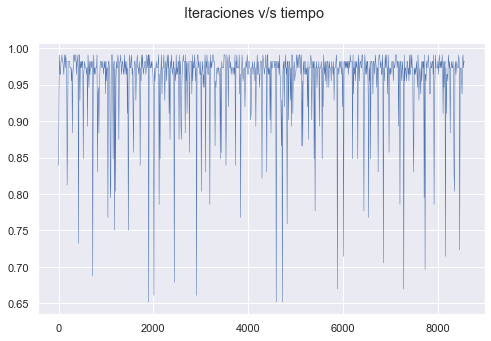

In [214]:
scores = list()
no_iterations = range(1, int(bound*10.5), 10)

for i in no_iterations:
    perceptron = Perceptron(tol=None, max_iter=i)
    perceptron.fit(X_train_vals, y_train_vals)

    train_acc = perceptron.score(X_train_vals, y_train_vals)
    scores.append(perceptron.score(X_val_vals, y_val_vals))
    test_acc = perceptron.score(X_test_vals, y_test_vals)
    
fig, ax1 = plt.subplots(figsize=(8, 5))

fig.suptitle('Iteraciones v/s tiempo')

ax1.plot(no_iterations, scores, '-', linewidth=0.5)

## Perceptrón con datos linealmente separables

In [215]:
from sklearn.model_selection import train_test_split

predictors = data.columns[:-1]
X = data[predictors]
info = data[predictors]

y = data["Result"]

X, y = convert_to_ls(X, y)
print("Datos convertidos?:", linear_separable(X, y))

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

scores = list()
no_iterations = range(1, int(bound*10.5), 10)

for i in no_iterations:
    perceptron = Perceptron(tol=None, max_iter=i)
    perceptron.fit(X_train_vals, y_train_vals)

    train_acc = perceptron.score(X_train_vals, y_train_vals)
    scores.append(perceptron.score(X_val_vals, y_val_vals))
    test_acc = perceptron.score(X_test_vals, y_test_vals)
    
fig, ax1 = plt.subplots(figsize=(8, 5))

fig.suptitle('Iteraciones v/s tiempo')

ax1.plot(no_iterations, scores, '-', linewidth=0.5)

(698, 9)
(698,)
2




ValueError: Length of passed values is 697, index implies 698.

# Dataset 2

## Carga dataset

In [156]:
data = pd.read_csv('datasets/Skin_NonSkin.txt', sep="\t")
print("Nan?: \n", data.isna().sum())

data.columns = ["B", "G", "R", "SkinNonSkin"]
print("Shape SkinNonSkin: ", data.shape)

Nan?: 
 74     0
85     0
123    0
1      0
dtype: int64
Shape SkinNonSkin:  (245056, 4)


## Análisis exploratorio

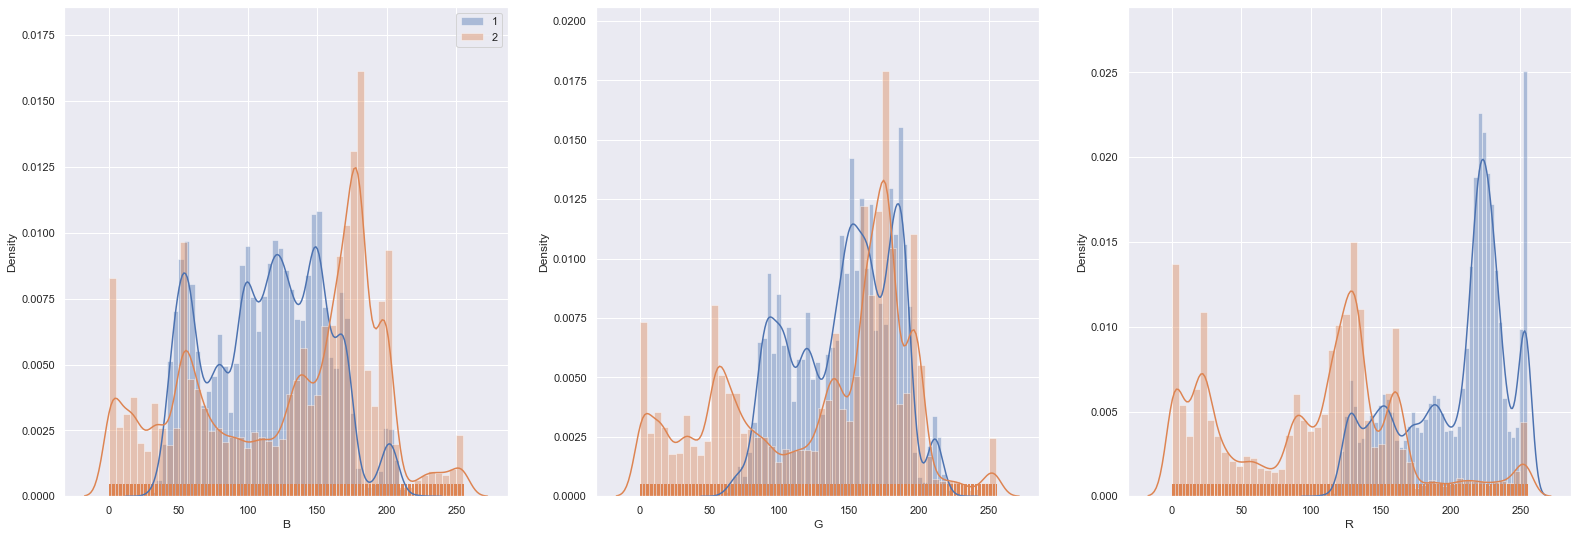

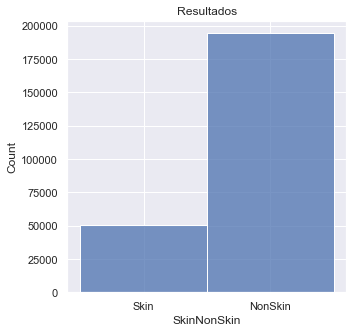

          B    G    R SkinNonSkin
0        73   84  122        Skin
1        72   83  121        Skin
2        70   81  119        Skin
3        70   81  119        Skin
4        69   80  118        Skin
...     ...  ...  ...         ...
245051  163  162  112     NonSkin
245052  163  162  112     NonSkin
245053  163  162  112     NonSkin
245054  163  162  112     NonSkin
245055  255  255  255     NonSkin

[245056 rows x 4 columns]


In [157]:
fig, axes = plt.subplots(figsize=(9*3, 9), nrows=1, ncols=3)

"""data[data["SkinNonSkin"]==1] = "Skin"
data[data["SkinNonSkin"]==2] = "NonSkin" """

for i, column in enumerate(data.columns[:-1]):
    for result in [1, 2]:
        target = data.loc[data['SkinNonSkin'] == result]
        sns.distplot(target[column], rug=True, kde=True, ax=axes[i], label=result)
    if i==0:
        axes[0].legend()

data.loc[data["SkinNonSkin"] == 1, "SkinNonSkin"] = "Skin"
data.loc[data["SkinNonSkin"] == 2, "SkinNonSkin"] = "NonSkin"

fig, ax = plt.subplots(figsize=(5, 5),nrows=1)
sns.histplot(data=data["SkinNonSkin"], palette="Blues_d",ax=ax, label=["Skin", "NonSkin"])
ax.set_title('Resultados')
plt.show()

print(data)

In [158]:
data.loc[data["SkinNonSkin"] == "Skin", "SkinNonSkin"] = 1
data.loc[data["SkinNonSkin"] == "NonSkin", "SkinNonSkin"] = -1

data["SkinNonSkin"] = data["SkinNonSkin"].astype(int)

predictors = data.columns[:-1]
x = data[predictors]
info = data[predictors]

y = data["SkinNonSkin"]

from itertools import permutations 

perm = list(permutations(data.columns[:-1], 1)) + list(permutations(data.columns[:-1], 2))

predictors = data.columns[:-1]
x = data[predictors]
info = data[predictors]

X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(x, y, info, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val, info_train, info_val = train_test_split(X_train, y_train, info_train, test_size=0.2, random_state=0)

X_train_vals = X_train.values; y_train_vals = y_train.values;
X_val_vals = X_val.values; y_val_vals = y_val.values;
X_test_vals = X_test.values; y_test_vals = y_test.values;

X, Y = convert_to_ls(X_val_vals, y_val_vals)

#print(linearly_separable(X, Y))
    
from pandas.plotting import scatter_matrix

data = pd.DataFrame(X, columns=["B", "G", "R"])
data["SkinNonSkin"] = Y

max_norm_x = max_norm(X)
g = gamma(X, Y)
bound = max_norm_x**2 / g**2

print("R:", max_norm_x)
print("Gamma: ", g)
print("Cota: ", bound)

(39209, 3)
(39209,)
(111327,)
(32909,)


ValueError: Shape of passed values is (111327, 1), indices imply (111327, 3)

[[2 2 2]
 [1 1 1]
 [2 2 2]
 ...
 [2 2 2]
 [2 2 2]
 [2 2 2]]
[2 1 2 ... 2 2 2]


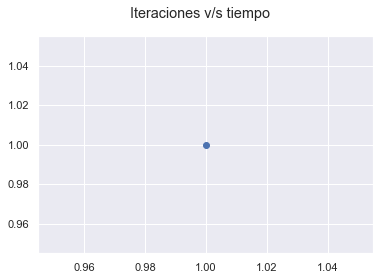

In [133]:
scores = list()

for i in range(1, int(bound*1.1), 1000):
    perceptron = Perceptron(tol=None, max_iter=i)
    perceptron.fit(X, Y)
    scores.append(perceptron.score(X, Y))

fig, ax1 = plt.subplots()

fig.suptitle('Iteraciones v/s tiempo')

ax1.plot(range(1, int(bound*1.1), 1000), scores, 'o-')

### Referencias
#### Binaries

* No Dataset breast-cancer-wisconsin
Dataset iris 